In [16]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split  

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [17]:
data = pd.read_csv('../data/SB/SBUX .csv')
print(data.dtypes)
print(data.head())

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
         Date   Open    High     Low   Close  Adj Close    Volume
0  2010-01-04  11.66  11.665  11.455  11.525   9.256213  16370000
1  2010-01-05  11.48  12.000  11.445  11.795   9.473062  30058800
2  2010-01-06  11.74  11.810  11.630  11.710   9.404798  14209600
3  2010-01-07  11.64  11.765  11.595  11.680   9.380702  10256000
4  2010-01-08  11.60  11.800  11.595  11.640   9.348577  10274800


In [18]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [19]:
data['Volume'] = data['Volume'].astype(float)

In [20]:
x = data.iloc[:,:-1]
y = data.iloc[:,5:6]

In [21]:
print(y)

                Volume
Date                  
2010-01-04  16370000.0
2010-01-05  30058800.0
2010-01-06  14209600.0
2010-01-07  10256000.0
2010-01-08  10274800.0
...                ...
2022-12-27   4402500.0
2022-12-28   3491500.0
2022-12-29   3976100.0
2022-12-30   3987800.0
2023-01-03   6606000.0

[3273 rows x 1 columns]


In [22]:
ms = MinMaxScaler()
ss = StandardScaler()

x_ss = ss.fit_transform(x)
y_ms = ms.fit_transform(y)

x_train = x_ss[:-400,:]
x_test = x_ss[-400:,:]
y_train = y_ms[:-400,:]
y_test = y_ms[-400:,:]

print('Training Shape', x_train.shape,y_train.shape)
print('Testing Shape', x_test.shape,y_test.shape)

Training Shape (2873, 5) (2873, 1)
Testing Shape (400, 5) (400, 1)


In [23]:
x_train_tensors = Variable(torch.Tensor(x_train))
x_test_tensors = Variable(torch.Tensor(x_test))
y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [24]:
x_train_tensors_f = torch.reshape(x_train_tensors,(x_train_tensors.shape[0],1,x_train_tensors.shape[1]))
x_test_tensors_f = torch.reshape(x_test_tensors,(x_test_tensors.shape[0],1,x_test_tensors.shape[1]))

In [25]:
print("Training Shape", x_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", x_test_tensors_f.shape, y_test_tensors.shape) 

Training Shape torch.Size([2873, 1, 5]) torch.Size([2873, 1])
Testing Shape torch.Size([400, 1, 5]) torch.Size([400, 1])


In [26]:
class LSTM(nn.Module):
    def __init__(self,num_class,input_size,hidden_size, num_layers,seq_length):
        super().__init__()

        self.num_classes = num_class
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,num_layers=num_layers,batch_first=True)
        self.fc_1 = nn.Linear(hidden_size,128)
        self.fc = nn.Linear(128,num_class)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size))
        output, (hn,cn) = self.lstm(x,(h_0,c_0))
        hn = hn.view(-1,self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out


In [27]:
num_epochs = 1000
learning_rate = 0.0001

input_size = 5
hidden_size= 2
num_layers = 1
num_classes = 1

model = LSTM(num_classes,input_size,hidden_size,num_layers,x_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)


In [28]:
for epoch in range(num_epochs):
    outputs = model.forward(x_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()

    optimizer.step()
    if epoch % 100 ==0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.15692
Epoch: 100, loss: 0.03490
Epoch: 200, loss: 0.01090
Epoch: 300, loss: 0.00853
Epoch: 400, loss: 0.00810
Epoch: 500, loss: 0.00781
Epoch: 600, loss: 0.00758
Epoch: 700, loss: 0.00742
Epoch: 800, loss: 0.00730
Epoch: 900, loss: 0.00723


In [29]:
df_x_ss = ss.transform(data.iloc[:, :-1]) 
df_y_ms = ms.transform(data.iloc[:, -1:]) 

df_x_ss = Variable(torch.Tensor(df_x_ss)) 
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1])) 

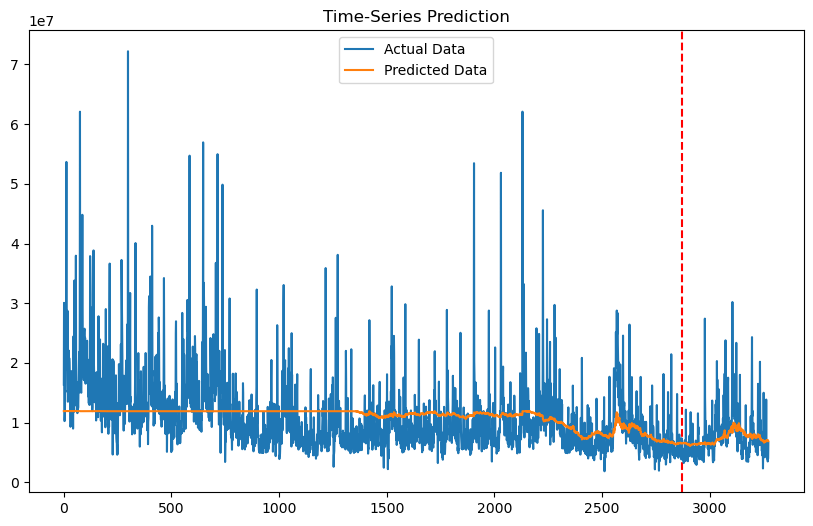

In [30]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy() 
label_y = df_y_ms.data.numpy()

predicted= ms.inverse_transform(predicted) 
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6)) 
plt.axvline(x=2873, c='r', linestyle='--') 

plt.plot(label_y, label='Actual Data') 
plt.plot(predicted, label='Predicted Data') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 